<a href="https://colab.research.google.com/github/ktaran-jeet/deepfake-image-generation/blob/main/GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Image creation using Deep Convolutional GAN:

In [26]:
import torch, torchvision
import torch.nn as nn
import torch.optim as optim
import torch.utils.data
import torchvision.transforms as transforms
import torchvision.utils as vutils

Datapreprocessing and loading

In [27]:
transform = transforms.Compose([
    transforms.Resize(64), ## the size of generated images
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5)),
])

dataset = torchvision.datasets.CIFAR10(root='./data', download= True, transform=transform)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=64, shuffle = True)

Files already downloaded and verified


In [33]:
#weight-initialization:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

Define generator architecture:

In [34]:
#Generator:
class Gen(nn.Module):

  def __init__(self):
    super(Gen,self).__init__()
    self.layer = nn.Sequential(
        nn.ConvTranspose2d(100, 512, 4, 1, 0, bias=False),
        nn.BatchNorm2d(512),
        nn.ReLU(True),
        nn.ConvTranspose2d(512, 256, 4, 2, 1, bias=False),
        nn.BatchNorm2d(256),
        nn.ReLU(True),
        nn.ConvTranspose2d(256, 128, 4, 2, 1, bias = False),
        nn.BatchNorm2d(128),
        nn.ReLU(True),
        nn.ConvTranspose2d(128, 64, 4, 2, 1, bias = False),
        nn.BatchNorm2d(64),
        nn.ReLU(True),
        nn.ConvTranspose2d(64, 3, 4, 2, 1, bias = False),
        nn.Tanh()
    )


  def forward(self, x):
    return self.layer(x)

Define Discriminator architecture:

In [35]:
#Discriminator:
class Dis(nn.Module):

  def __init__(self):
    super(Dis,self).__init__()
    self.layer = nn.Sequential(
    nn.Conv2d(3, 64, 4, 2, 1, bias = False),
    nn.LeakyReLU(0.2, inplace = True),
    nn.Conv2d(64, 128, 4, 2, 1, bias = False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace = True),
    nn.Conv2d(128, 256, 4, 2, 1, bias = False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace = True),
    nn.Conv2d(256, 512, 4, 2, 1, bias = False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace = True),
    nn.Conv2d(512, 1, 4, 1, 0, bias = False),
    nn.Sigmoid()
    )

  def forward(self, x):
    op = self.layer(x)
    return op.view(-1)

In [37]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
gen = Gen()
gen.apply(weights_init)
gen = gen.to(device)
print(gen)

Using device: cuda
Gen(
  (layer): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13):

In [40]:
dis = Dis()
dis.apply(weights_init)
dis = dis.to(device)
print(dis)

Dis(
  (layer): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)


Model Training:

In [41]:
criterion = nn.BCELoss()
optimizerG = optim.Adam(gen.parameters(), lr=0.0002,  betas = (0.5, 0.999))
optimizerD = optim.Adam(dis.parameters(), lr=0.0002,  betas = (0.5, 0.999))

num_epochs = 25
for epoch in range(num_epochs):

  for i, data in enumerate(dataloader, 0):

    dis.zero_grad()
    #Train dis. with real image from dataset:
    realimage, _ = data
    realimage = realimage.to(device)
    inputsize = realimage.size(0)
    target_real = torch.ones(inputsize, device=device)
    output_real = dis(realimage)
    errdis_real = criterion(output_real, target_real)

    #Train dis. with fake image generated by Gen:
    noise = torch.randn(inputsize, 100, 1, 1, device=device)
    fakeimage = gen(noise)
    target_fake = torch.zeros(inputsize, device=device)
    output_fake = dis(fakeimage.detach())
    errdis_fake = criterion(output_fake, target_fake)

    errdis = errdis_real + errdis_fake
    errdis.backward()
    optimizerD.step()

    #Update weights for gen:
    gen.zero_grad()
    target_gen = torch.ones(inputsize, device=device)
    output_gen = dis(fakeimage)
    errgen = criterion(output_gen, target_gen)
    errgen.backward()
    optimizerG.step()

    if i % 10 == 0:
      print('[%d/%d][%d/%d] Loss_D: %.4f Loss_G: %.4f' %
              (epoch, 25, i, len(dataloader), errgen.item(), errdis.item()))

    if i % 100 == 0:
      vutils.save_image(realimage, './results/real_samples.png', normalize=True)
      fake = gen(noise)
      vutils.save_image(fake.detach(), './results/fake_samples_epoch_%03d.png' % epoch, normalize=True)



[0/25][0/782] Loss_D: 5.4720 Loss_G: 1.5285
[0/25][10/782] Loss_D: 8.2479 Loss_G: 0.4681
[0/25][20/782] Loss_D: 10.3761 Loss_G: 0.2206
[0/25][30/782] Loss_D: 7.2811 Loss_G: 0.2069
[0/25][40/782] Loss_D: 12.1891 Loss_G: 0.0705
[0/25][50/782] Loss_D: 27.7877 Loss_G: 0.2912
[0/25][60/782] Loss_D: 8.9025 Loss_G: 0.0124
[0/25][70/782] Loss_D: 21.5999 Loss_G: 0.6922
[0/25][80/782] Loss_D: 8.4302 Loss_G: 0.1598
[0/25][90/782] Loss_D: 22.5956 Loss_G: 0.5000
[0/25][100/782] Loss_D: 15.1207 Loss_G: 0.0505
[0/25][110/782] Loss_D: 22.2525 Loss_G: 0.0449
[0/25][120/782] Loss_D: 7.5049 Loss_G: 0.1303
[0/25][130/782] Loss_D: 21.2449 Loss_G: 1.0459
[0/25][140/782] Loss_D: 4.6310 Loss_G: 0.3093
[0/25][150/782] Loss_D: 4.6325 Loss_G: 0.2257
[0/25][160/782] Loss_D: 6.8773 Loss_G: 0.1180
[0/25][170/782] Loss_D: 4.7217 Loss_G: 0.3906
[0/25][180/782] Loss_D: 3.6986 Loss_G: 0.2734
[0/25][190/782] Loss_D: 2.1493 Loss_G: 0.7144
[0/25][200/782] Loss_D: 4.3221 Loss_G: 0.3365
[0/25][210/782] Loss_D: 6.8212 Loss_G

Generated Image:



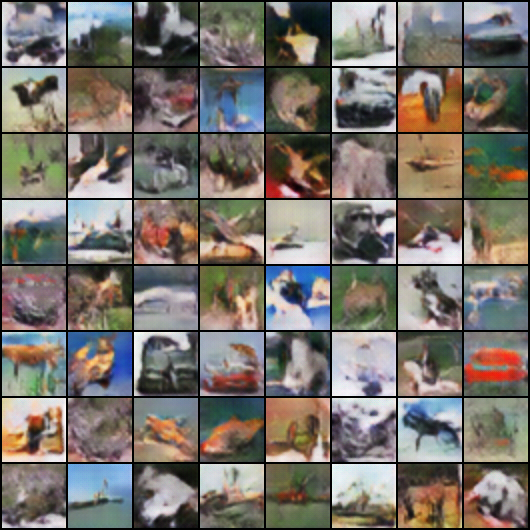

Real Image:



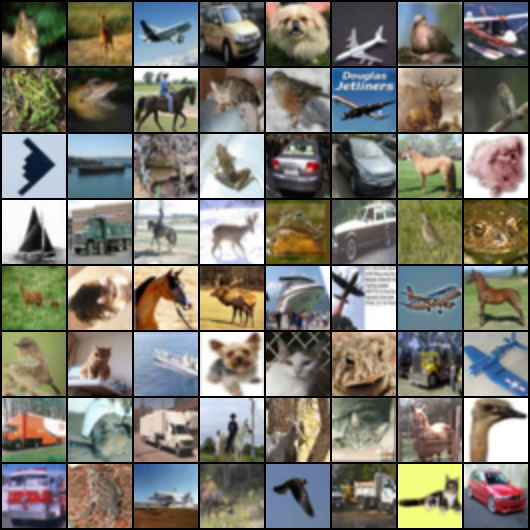

In [55]:
from IPython.display import Image, display
print("Generated Image:\n")
display(Image("./results/fake_samples_epoch_024.png"))
print("Real Image:\n")
display(Image(filename="./results/real_samples.png"))